In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from coniferest.datasets import plasticc_gp
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
import random

In [24]:
# Уменьшаем вариативность весов
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Загрузка данных
data, metadata = plasticc_gp()
data = data[:, :-11]
filtered_data = data[(data >= -1).all(axis=1) & (data <= 1).all(axis=1)]

# Определение VAE
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 7),
            nn.ReLU(),
            nn.Linear(7, 2),
            nn.ReLU()
        )
        self.mu_layer = nn.Linear(2, latent_dim)
        self.logvar_layer = nn.Linear(2, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 2),
            nn.ReLU(),
            nn.Linear(2, 7), 
            nn.ReLU(),
            nn.Linear(7, input_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Функция потерь для VAE
def loss_function(recon_x, x, mu, logvar, kld_weight=0.6, recon_weight=1.2):
    BCE = recon_weight * nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = kld_weight * -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Подготовка данных
class MyDataset(Dataset):
    def __init__(self, filtered_data):
        self.data = filtered_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32)



In [4]:
# Разделение данных на обучающую и валидационную выборки
train_data = filtered_data[:int(0.7 * len(data))]
val_data = filtered_data[int(0.3 * len(data)):]

train_dataset = MyDataset(train_data)
val_dataset = MyDataset(val_data)

train_dataloader = DataLoader(train_dataset, batch_size=22, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=22, shuffle=False)

# Параметры модели
input_dim = data.shape[1]
latent_dim = 2

# Создание модели
model = VariationalAutoencoder(input_dim, latent_dim)

# Оптимизация
optimizer = optim.SGD(model.parameters(), lr=0.000025)

# Обучение модели
epochs = 50
kld_weight = 1.5
recon_weight = 1.0

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch)
        loss = loss_function(recon_batch, batch, mu, logvar, kld_weight, recon_weight)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    train_loss /= len(train_dataloader.dataset)
    train_losses.append(train_loss)
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss}")

    # Оценка на валидационной выборке
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            recon_batch, mu, logvar = model(batch)
            loss = loss_function(recon_batch, batch, mu, logvar, kld_weight, recon_weight)
            val_loss += loss.item()
    
    val_loss /= len(val_dataloader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch: {epoch+1}, Validation Loss: {val_loss}")



/media/timofey/aad run/coniferest15/lib/python3.11/site-packages/torch/autograd/graph.py:823: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 1, Train Loss: 94.28427229339951
Epoch: 1, Validation Loss: 72.37771589437108
Epoch: 2, Train Loss: 50.27294721531518
Epoch: 2, Validation Loss: 35.94290013525896
Epoch: 3, Train Loss: 26.647846197713136
Epoch: 3, Validation Loss: 21.16834755612027
Epoch: 4, Train Loss: 19.17714948779011
Epoch: 4, Validation Loss: 17.398989357006776
Epoch: 5, Train Loss: 17.49669675740019
Epoch: 5, Validation Loss: 16.528868568930655
Epoch: 6, Train Loss: 17.15208699333436
Epoch: 6, Validation Loss: 16.34526192002995
Epoch: 7, Train Loss: 17.06258614694065
Epoch: 7, Validation Loss: 16.27723817916433
Epoch: 8, Train Loss: 17.03945936621394
Epoch: 8, Validation Loss: 16.22614897588256
Epoch: 9, Train Loss: 17.017810946369586
Epoch: 9, Validation Loss: 16.24241310320083
Epoch: 10, Train Loss: 17.005919894922446
Epoch: 10, Validation Loss: 16.218541380706107
Epoch: 11, Train Loss: 17.00708005088797
Epoch: 11, Validation Loss: 16.221260251512952
Epoch: 12, Train Loss: 16.99762998200371
Epoch: 12, Va

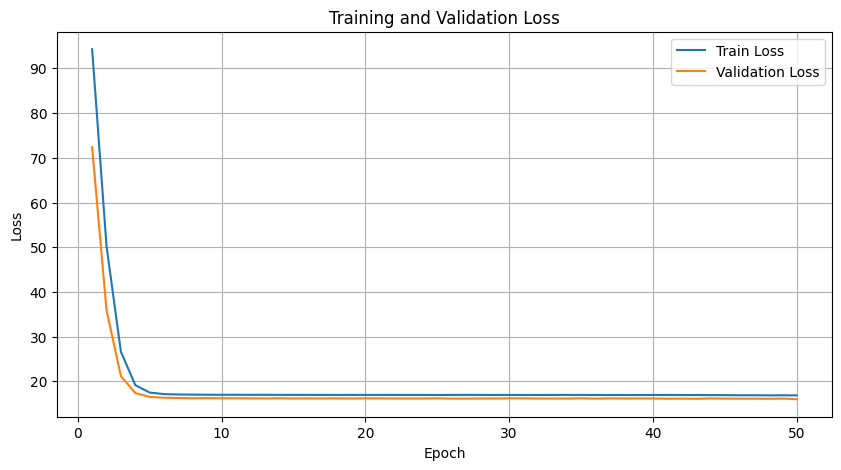

In [5]:
# Построение графика потерь
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)



Индексы 100 образцов с наименьшей плотностью вероятности: [1779 2724 5177 6856 2883 6009 6161 6993 3788  177 3176 1727 2074 2980
 2200 6815 4378 5650   60 6904   26 1603 1111 2672 7153  294  463  206
 4552  426  448  459 2666 5948  639 6826 3389 1080  218 2339  751 4462
 4625 3594 1388 5798  394 4114 2680 6209 1146 6735 1409  552 2453 3461
 3207 4406  153  133 3464 5625  364 3361 6001   14 1538 6008 6427 4367
  359 1987  421 5422  201  280  770 5606 2260 2658 5172 7077  291 5550
  720 5937  371 6357 1529  499 5560 5904 3525 1329  235  209  234  465
 2005 5602]
Плотности вероятности для этих образцов: [8.02704124e-16 8.08501206e-06 7.79224106e-05 2.13980932e-04
 5.22360391e-04 5.85215630e-04 6.21634797e-04 6.92171044e-04
 1.22555147e-03 2.05188586e-03 2.27829725e-03 2.65648444e-03
 3.40821892e-03 3.98342880e-03 4.18787221e-03 9.32728636e-03
 9.63337828e-03 1.05473940e-02 1.36220700e-02 1.39418578e-02
 2.26076936e-02 2.32063981e-02 2.40977677e-02 2.53233050e-02
 2.86317122e-02 2.89697133

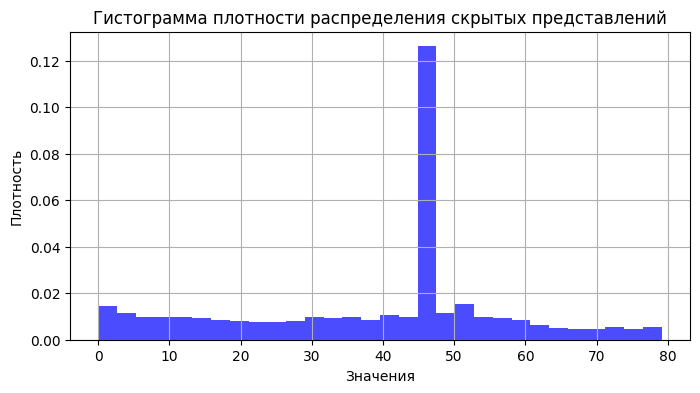

In [17]:
# Получение скрытых представлений
latent_representations = []

model.eval()
with torch.no_grad():
    for sample in filtered_data:
        sample_tensor = torch.tensor(sample, dtype=torch.float32).unsqueeze(0)
        mu, logvar = model.encode(sample_tensor)
        latent_representations.append(mu.numpy())  # Преобразуем в NumPy массив

# Преобразуем список в двумерный массив NumPy
latent_representations = np.array(latent_representations).squeeze()  # Удаляем лишние размерности

# Параметры многомерного нормального распределения
mean = np.mean(latent_representations, axis=0)
cov = np.cov(latent_representations, rowvar=False)

# Вычисление плотности вероятности
pdf_values = multivariate_normal.pdf(latent_representations, mean=mean, cov=cov)

# Сортировка по убыванию и выбор 100 самых маленьких
sorted_indices = np.argsort(pdf_values)  # Сортируем по возрастанию
top_100_indices = sorted_indices[:100]
top_100_pdf_values = pdf_values[top_100_indices]

# Вывод результатов
print("Индексы 100 образцов с наименьшей плотностью вероятности:", top_100_indices)
print("Плотности вероятности для этих образцов:", top_100_pdf_values)

# Построение гистограммы для плотности распределения (должен быть пик)
plt.figure(figsize=(8, 4))
plt.hist(pdf_values, bins=30, density=True, alpha=0.7, color='blue')
plt.title('Гистограмма плотности распределения скрытых представлений')
plt.xlabel('Значения')
plt.ylabel('Плотность')
plt.grid()
plt.show()

(array([3411.,  549.,  416.,  460.,  557.,  702.,  584.,  335.,  141.,
          30.]),
 array([-0.09352093, -0.04239992,  0.00872108,  0.05984209,  0.1109631 ,
         0.1620841 ,  0.2132051 ,  0.26432613,  0.31544712,  0.36656812,
         0.41768914]),
 <BarContainer object of 10 artists>)

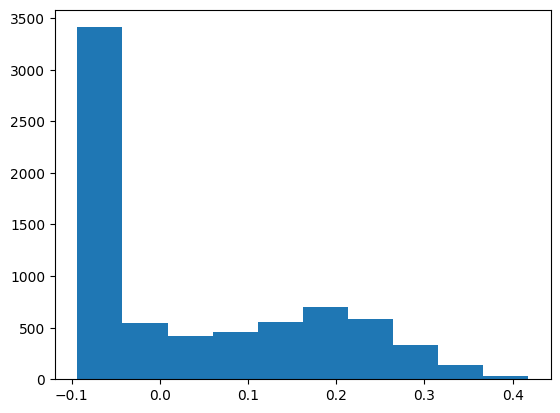

In [26]:
plt.hist(latent_representations[:, 1])

Индексы 100 образцов с наибольшей реконструкционной ошибкой: [1579 2025 3330 1283  891 1373 1219 3788 6125  399  252 7157 2309 2243
 1815 6642 6310  519 3153 1490 2049  390 1436 4533 6751 7093 2030 1003
 2083 6771 5470 2581 6948 4367 6856 1322 6627  116 1480 2510 4397 1227
 6859 2222  799 3397 6962 5044 4622 2622 2368 1122 1087 5073 5411 5288
 2227 4093 1317  901 1823 4320 6672 1520 5157 1568 5524 7049 1865 5362
 6323 3140 3826 1199 6364 5660 6036 6421  932 7086 5370 4762 4259 2277
 2426 5778 4151 5569 5862  417 2028 5457 4329 5439 2917 5324 5685 4853
 2511 3463]


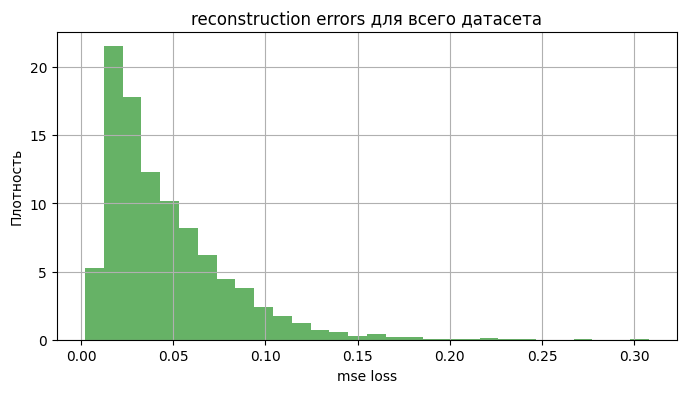

In [19]:
# Рассчет reconstruction errors для каждого образца
reconstruction_errors = []

model.eval()
with torch.no_grad():
    for sample in filtered_data:
        sample_tensor = torch.tensor(sample, dtype=torch.float32).unsqueeze(0)
        output, mu, logvar = model(sample_tensor)
        reconstruction_error = nn.functional.mse_loss(output, sample_tensor).item()
        reconstruction_errors.append(reconstruction_error)

# Преобразуем в массив NumPy для удобства
reconstruction_errors = np.array(reconstruction_errors)

# Сортировка ошибок и выбор первых 100
sorted_indices = np.argsort(reconstruction_errors)[::-1]  # Сортируем по убыванию
top_100_indices = sorted_indices[:100]
top_100_errors = reconstruction_errors[top_100_indices]

# Должен быть пик
# Вывод результатов
print("Индексы 100 образцов с наибольшей реконструкционной ошибкой:", top_100_indices)
#print("Реконструкционные ошибки для этих образцов:", top_100_errors)

plt.figure(figsize=(8, 4))
plt.hist(reconstruction_errors, bins=30, density=True, alpha=0.6, color='g')
plt.title(f'reconstruction errors для всего датасета')
plt.xlabel('mse loss')
plt.ylabel('Плотность')
plt.grid(True)
plt.show()

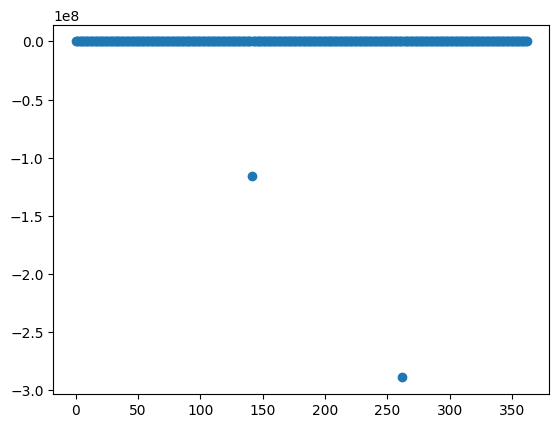

In [14]:
plt.scatter(np.arange(len(data[2921])), data[2921])

In [15]:
data[2921].min()

np.float32(-289481800.0)